In [1]:
!pip install lightgbm
!pip install optuna
!pip install pandarallel
!pip install statsmodels
!pip install modin[ray] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 25.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 25.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 582.2/582.2 kB 25.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
  Preparing metadata (setup.py) ... done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16713 sha256=cfcdc3b56a1080863b2e6f79c7f8381994125dac89495b96d61ed41c4cee2427
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
import optuna
#import ta  # Technical Analysis library
from sklearn.model_selection import train_test_split
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)  # Optional: shows progress

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
trains_df = pd.read_parquet("/kaggle/input/train-test/train.parquet")
#test_df = pd.read_parquet("/kaggle/input/train-test/test.parquet")

In [4]:
trains_df.index.duplicated().sum()
print("Training index dtype:", trains_df.index.dtype)
print("First timestamp:", trains_df.index[0])
print("Last timestamp:", trains_df.index[-1])

Training index dtype: datetime64[ns]
First timestamp: 2023-03-01 00:00:00
Last timestamp: 2024-02-29 23:59:00


In [5]:
time_diffs = trains_df.index.to_series().diff()
print(time_diffs.value_counts())

timestamp
0 days 00:01:00    525613
0 days 00:02:00       117
0 days 00:03:00        56
0 days 00:04:00        18
0 days 00:08:00        14
0 days 00:06:00        13
0 days 00:05:00        11
0 days 00:07:00         7
0 days 00:15:00         4
0 days 00:20:00         4
0 days 00:11:00         4
0 days 00:13:00         3
0 days 00:12:00         3
0 days 00:22:00         2
0 days 00:18:00         2
0 days 00:10:00         2
0 days 00:14:00         2
0 days 00:09:00         2
0 days 00:27:00         2
0 days 00:32:00         1
0 days 00:35:00         1
0 days 00:30:00         1
0 days 00:33:00         1
0 days 00:31:00         1
0 days 00:21:00         1
0 days 00:17:00         1
Name: count, dtype: int64


In [6]:
# Reindex to uniform 1-minute intervals
trains_df = trains_df.sort_index()
full_range = pd.date_range(start=trains_df.index.min(), end=trains_df.index.max(), freq='1min')
df_reindexed = trains_df.reindex(full_range)

In [7]:
time_diffs = df_reindexed.index.to_series().diff()
print(time_diffs.value_counts())

0 days 00:01:00    527039
Name: count, dtype: int64


In [8]:
missing_timestamps = df_reindexed[df_reindexed.isnull().any(axis=1)]
print(f"Number of missing timestamps: {len(missing_timestamps)}")
print("Example gaps:\n", missing_timestamps.head())

Number of missing timestamps: 1153
Example gaps:
                      bid_qty  ask_qty  buy_qty  sell_qty  volume  X1  X2  X3  \
2023-04-08 08:30:00      NaN      NaN      NaN       NaN     NaN NaN NaN NaN   
2023-04-08 13:00:00      NaN      NaN      NaN       NaN     NaN NaN NaN NaN   
2023-04-09 20:21:00      NaN      NaN      NaN       NaN     NaN NaN NaN NaN   
2023-04-09 20:22:00      NaN      NaN      NaN       NaN     NaN NaN NaN NaN   
2023-04-10 02:43:00      NaN      NaN      NaN       NaN     NaN NaN NaN NaN   

                     X4  X5  ...  X882  X883  X884  X885  X886  X887  X888  \
2023-04-08 08:30:00 NaN NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2023-04-08 13:00:00 NaN NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2023-04-09 20:21:00 NaN NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2023-04-09 20:22:00 NaN NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2023-04-10 02:43:00 NaN NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   



In [9]:
# Step 1: Track where missing
df_reindexed['was_missing'] = df_reindexed.isnull().any(axis=1).astype(int)

# Step 2: Forward-fill missing data
df_reindexed = df_reindexed.ffill()


In [10]:
print(df_reindexed['was_missing'].unique)
df_reindexed['was_missing'].value_counts()

<bound method Series.unique of 2023-03-01 00:00:00    0
2023-03-01 00:01:00    0
2023-03-01 00:02:00    0
2023-03-01 00:03:00    0
2023-03-01 00:04:00    0
                      ..
2024-02-29 23:55:00    0
2024-02-29 23:56:00    0
2024-02-29 23:57:00    0
2024-02-29 23:58:00    0
2024-02-29 23:59:00    0
Freq: min, Name: was_missing, Length: 527040, dtype: int64>


was_missing
0    525887
1      1153
Name: count, dtype: int64

In [11]:
train_df = df_reindexed.loc['2023-11-01':'2024-02-29']

In [12]:
print(train_df.shape)
train_df.head()

(174240, 897)


,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X883,X884,X885,X886,X887,X888,X889,X890,label,was_missing
2023-11-01 00:00:00,6.016,1.991,27.437,92.354,119.791,-1.049712,-0.301246,-0.820088,-1.153650,-0.701695,...,1.543497,0.000919,0.027573,0.137934,0.230145,0.178052,0.146182,0.508278,-0.810797,0
2023-11-01 00:01:00,16.064,1.574,199.885,176.155,376.040,-0.837311,0.112323,-0.382535,-0.716900,-0.485250,...,1.544525,0.000918,0.026713,0.135688,0.228251,0.177562,0.145980,0.507927,-0.988213,0
2023-11-01 00:02:00,3.826,3.675,229.490,201.687,431.177,-0.407687,0.883247,0.461335,0.140015,-0.055166,...,1.545839,0.000874,0.025865,0.133471,0.226368,0.177071,0.145779,0.507575,-0.718116,0
2023-11-01 00:03:00,5.186,5.125,71.494,104.400,175.894,-0.831347,0.032660,-0.373534,-0.695710,-0.474869,...,1.545830,0.000814,0.025037,0.131286,0.224499,0.176581,0.145577,0.507223,-0.853308,0
2023-11-01 00:04:00,6.908,4.619,89.613,386.974,476.587,-0.442651,0.736412,0.390831,0.080343,-0.085461,...,1.547377,0.000847,0.024268,0.129153,0.222653,0.176095,0.145376,0.506873,-0.600268,0


In [13]:
# Convert float64 to float32
train_df = train_df.astype({col: 'float32' for col in train_df.select_dtypes('float64').columns})
# Convert float64 to float32
#test_df = test_df.astype({col: 'float32' for col in test_df.select_dtypes('float64').columns})

In [15]:
train_df.isnull().values.any()
train_df.isnull().sum()
total_missing = train_df.isnull().sum().sum()
if total_missing == 0:
    print("✅ No missing values found in the dataset.")
else:
    print(f"⚠️ Total missing value")

✅ No missing values found in the dataset.


In [16]:
constant_cols = [col for col in train_df.columns if train_df[col].nunique(dropna=True) == 1]
print("Columns with all unique values:")
print(constant_cols)

Columns with all unique values:
['X697', 'X698', 'X699', 'X700', 'X701', 'X702', 'X703', 'X704', 'X705', 'X706', 'X707', 'X708', 'X709', 'X710', 'X711', 'X712', 'X713', 'X714', 'X715', 'X716', 'X717', 'X864', 'X867', 'X869', 'X870', 'X871', 'X872']


In [17]:
train_df = train_df.drop(columns = constant_cols)
print(f"✅ Removed {len(constant_cols)} constant columns")
print(f"📊 New shape: {train_df.shape}")

✅ Removed 27 constant columns
📊 New shape: (174240, 870)


In [18]:
train_df.describe()

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X883,X884,X885,X886,X887,X888,X889,X890,label,was_missing
count,174240.000000,174240.000000,174240.000000,174240.000000,174240.000000,174240.000000,174240.000000,174240.000000,174240.000000,174240.000000,...,174240.000000,174240.000000,174240.000000,174240.000000,174240.000000,174240.000000,174240.000000,174240.000000,174240.000000,174240.000000
mean,5.924511,5.948030,105.383667,106.463249,211.846924,-0.001679,-0.000213,-0.000288,-0.000303,-0.000142,...,1.974072,0.495374,0.495242,0.495058,0.494825,0.494281,0.493887,0.988971,0.073390,0.001739
std,9.012920,9.184986,223.586823,226.742249,428.320251,0.584457,0.658676,0.837030,0.933138,0.506778,...,0.573478,0.699085,0.685364,0.671995,0.654372,0.604154,0.537298,0.837995,1.022474,0.041665
min,0.001000,0.001000,0.000000,0.000000,0.000000,-2.787539,-5.861927,-6.125439,-6.093792,-2.855040,...,0.840253,0.000004,0.000006,0.000009,0.000027,0.003903,0.015654,0.092913,-11.447981,0.000000
25%,1.681750,1.678000,24.552000,25.265750,56.146500,-0.398998,-0.360430,-0.511679,-0.600056,-0.336942,...,1.517112,0.000154,0.000185,0.000233,0.000992,0.033000,0.066401,0.247022,-0.425474,0.000000
50%,4.061000,4.096000,49.716499,50.972500,105.716003,-0.014165,-0.004337,-0.012863,-0.018823,-0.010601,...,1.919933,0.000559,0.000915,0.004949,0.042255,0.129269,0.167569,0.637598,0.039711,0.000000
75%,7.906250,7.889000,106.271254,108.011501,214.920254,0.390253,0.357628,0.500920,0.587279,0.328451,...,2.316182,1.463319,1.381685,1.358660,1.194218,1.102871,0.993384,1.685613,0.536088,0.000000
max,719.939026,784.140991,13782.646484,13458.135742,20794.742188,2.972741,4.946897,4.769417,4.969156,2.424480,...,4.710715,1.584170,1.584170,1.584170,1.584170,1.583717,1.557770,2.769462,10.128518,1.000000


In [20]:
# Calculate skewness
skewed_features = train_df.skew().sort_values(ascending=False)

# Display top skewed features
print("Top 15 most skewed features:")
print(skewed_features.head(15))

Top 15 most skewed features:
X873           98.018501
X874           95.313087
X648           90.693878
X636           60.752319
X645           57.769756
X624           49.420223
X618           44.509930
X597           40.552612
X630           38.913895
X595           35.424999
X633           31.056313
X642           27.132912
was_missing    23.917799
bid_qty        22.001966
X621           21.778337
dtype: float64


In [21]:
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).sum()

outlier_counts = train_df.apply(count_outliers).sort_values(ascending=False)

print("Top 15 features with most outliers:")
print(outlier_counts.head(15))


Top 15 features with most outliers:
X104    84592
X62     84592
X146    84592
X110    84305
X152    84305
X68     84305
X593    83507
X309    83340
X393    83340
X351    83340
X357    82792
X315    82792
X399    82792
X74     81255
X116    81255
dtype: int64


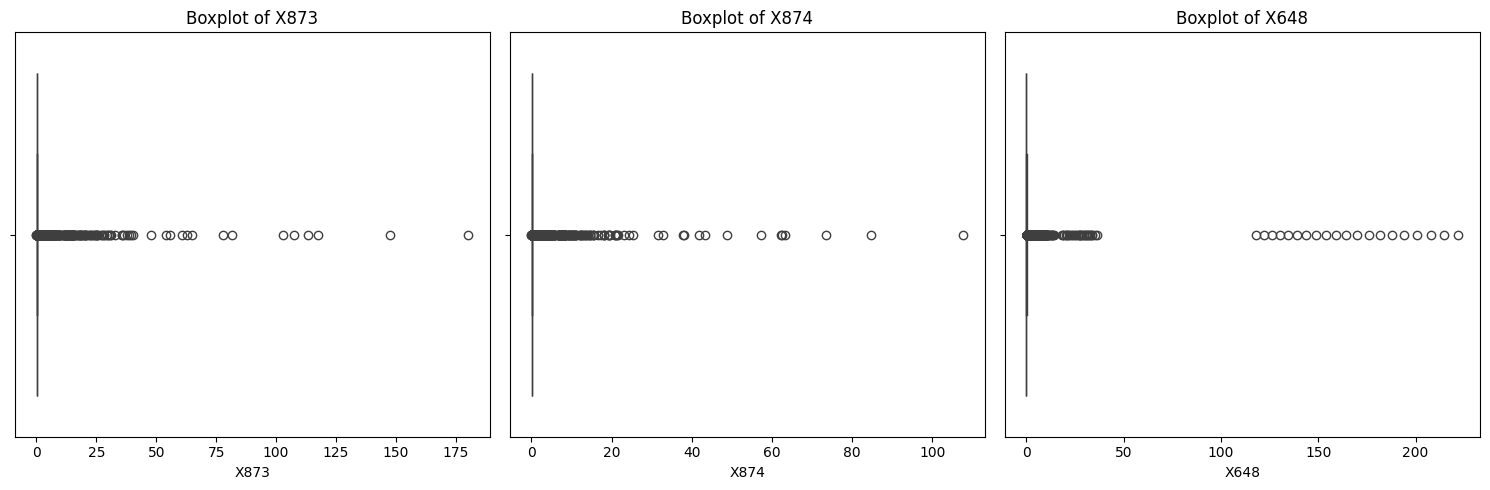

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

top_skewed = skewed_features.head(3).index

plt.figure(figsize=(15, 5))
for i, col in enumerate(top_skewed):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x=train_df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


In [16]:
train_df['spread'] = train_df['ask_qty'] - train_df['bid_qty']

/tmp/ipykernel_10/1201633132.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['spread'] = train_df['ask_qty'] - train_df['bid_qty']


In [17]:
print(train_df)

                       bid_qty  ask_qty     buy_qty    sell_qty      volume  \
2023-11-01 00:00:00   6.016000    1.991   27.437000   92.353996  119.791000   
2023-11-01 00:01:00  16.063999    1.574  199.884995  176.154999  376.040009   
2023-11-01 00:02:00   3.826000    3.675  229.490005  201.686996  431.177002   
2023-11-01 00:03:00   5.186000    5.125   71.494003  104.400002  175.893997   
2023-11-01 00:04:00   6.908000    4.619   89.612999  386.973999  476.587006   
...                        ...      ...         ...         ...         ...   
2024-02-29 23:55:00   4.163000    6.805   39.036999   55.351002   94.388000   
2024-02-29 23:56:00   2.290000    4.058  110.200996   67.170998  177.371994   
2024-02-29 23:57:00   5.237000    3.640   70.499001   30.753000  101.251999   
2024-02-29 23:58:00   5.731000    4.901   22.365000   52.195000   74.559998   
2024-02-29 23:59:00   3.925000    3.865   86.584999  217.136993  303.721985   

                           X1        X2        X3  

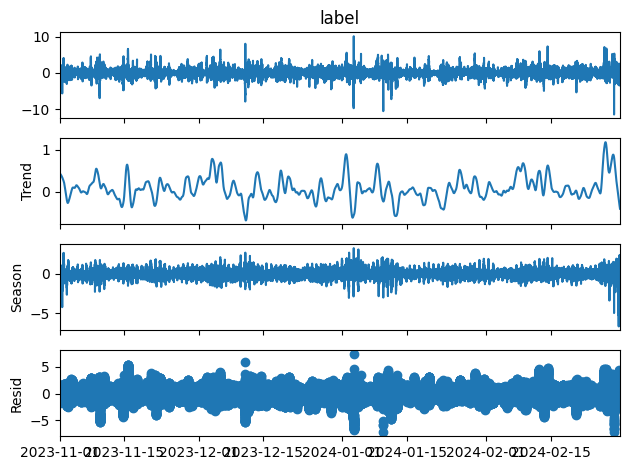

In [18]:
from statsmodels.tsa.seasonal import STL
decomp = STL(train_df['label'], period=24*60).fit()  # Daily seasonality for minute data
decomp.plot().show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging

# Setup logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class AdvancedOutlierHandler:
    def __init__(self):
        self.bounds = {}  # Store bounds for each column

    def detect_treat(self, df, cols, method='zscore', window_size=60):
        """
        Detects and treats outliers using specified method.
        Stores bounds for reuse (e.g., test set).
        """
        clean_df = df.copy()

        for col in cols:
            logger.info(f"\nProcessing column: {col} using {method.upper()}")

            if method == 'iqr':
                q1 = clean_df[col].quantile(0.25)
                q3 = clean_df[col].quantile(0.75)
                iqr = q3 - q1
                upper = q3 + 3 * iqr
                lower = q1 - 3 * iqr

            elif method == 'zscore':
                roll_mean = clean_df[col].rolling(window_size, min_periods=1).mean()
                roll_std = clean_df[col].rolling(window_size, min_periods=1).std().replace(0, 1e-6)
                upper = roll_mean + 3 * roll_std
                lower = roll_mean - 3 * roll_std

            elif method == 'quantile':
                lower = clean_df[col].quantile(0.001)
                upper = clean_df[col].quantile(0.999)

            else:
                raise ValueError("Unsupported method. Choose from 'iqr', 'zscore', or 'quantile'.")

            # Store bounds
            self.bounds[col] = {'lower': lower, 'upper': upper}

            # Winsorization
            before_outliers = ((clean_df[col] < lower) | (clean_df[col] > upper)).sum()
            clean_df[col] = np.where(
                clean_df[col] > upper, upper,
                np.where(clean_df[col] < lower, lower, clean_df[col])
            )
            after_outliers = ((clean_df[col] < lower) | (clean_df[col] > upper)).sum()
            logger.info(f"Outliers treated in {col}: {before_outliers} → {after_outliers}")

        return clean_df

    def transform(self, df, cols):
        """
        Apply stored bounds (from training) to a new DataFrame (e.g., test set).
        """
        clean_df = df.copy()

        for col in cols:
            if col not in self.bounds:
                raise ValueError(f"No bounds found for column {col}. Run detect_treat first.")

            upper = self.bounds[col]['upper']
            lower = self.bounds[col]['lower']

            if isinstance(upper, pd.Series):
                # Time-dependent bounds (z-score)
                upper = upper.reset_index(drop=True)
                lower = lower.reset_index(drop=True)
                clean_df[col] = np.where(
                    clean_df[col] > upper, upper,
                    np.where(clean_df[col] < lower, lower, clean_df[col])
                )
            else:
                # Static bounds (iqr or quantile)
                clean_df[col] = np.where(
                    clean_df[col] > upper, upper,
                    np.where(clean_df[col] < lower, lower, clean_df[col])
                )

        logger.info("Outlier treatment applied to new data.")
        return clean_df

    def plot_feature(self, df_before, df_after, feature_name, save_path=None):
        """
        Plot feature before and after treatment for comparison.
        """
        plt.figure(figsize=(15, 5))
        plt.plot(df_before[feature_name], label='Before', alpha=0.6)
        plt.plot(df_after[feature_name], label='After', alpha=0.6)
        plt.title(f'Outlier Treatment: {feature_name}')
        plt.legend()
        if save_path:
            plt.savefig(save_path)
            logger.info(f"Plot saved to: {save_path}")
            plt.close()
        else:
            plt.show()


In [55]:
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew
from pandarallel import pandarallel
import numpy as np
import pandas as pd

pandarallel.initialize(progress_bar=False)

class AdvancedFeatureGenerator:
    def __init__(self):
        self.scaler = PowerTransformer() 
        self.lag_values = {}
        self.stationarity_cache = {}

    def make_safe_features(self, df):
        df = df.copy()

        df['hour'] = df.index.hour
        df['day_of_week'] = df.index.dayofweek
        df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    
        # Time-based cyclic features
        df['time_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
        df['time_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
        df['day_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
        df['day_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)

        # Market microstructure features
        df['qty_imbalance'] = (df['bid_qty'] - df['ask_qty']) / (df['bid_qty'] + df['ask_qty'] + 1e-6)
        df['trade_imbalance'] = (df['buy_qty'] - df['sell_qty']) / (df['buy_qty'] + df['sell_qty'] + 1e-6)
        df['total_qty'] = df['bid_qty'] + df['ask_qty'] + df['buy_qty'] + df['sell_qty']

        return df
        
    def make_temporal_features(self, df, is_train=False):
        df = df.copy()
        base_cols = ['volume', 'bid_qty', 'buy_qty', 'ask_qty', 'sell_qty']

        lags = [1, 2, 3, 5]
        windows = [5]
        stats = ['mean', 'std', 'skew']

        for col_name in base_cols:
            # Lag features
            for lag in lags:
                col = f'{col_name}_lag_{lag}'
                if is_train:
                    df[col] = df[col_name].shift(lag)
                    self.lag_values[col] = df[col_name].iloc[-lag:].values
                else:
                    df[col] = np.concatenate(
                        [self.lag_values.get(col, np.zeros(lag)), 
                         [np.nan] * (len(df) - lag)]
                    )[:len(df)]

            # Rolling statistical features
            for window in windows:
                series = df[col_name].shift(1).rolling(window)
                for stat in stats:
                    col = f'{col_name}_rolling_{stat}_{window}'
                    if stat == 'mean':
                        df[col] = series.mean()
                    elif stat == 'std':
                        df[col] = series.std()
                    elif stat == 'skew':
                        df[col] = series.parallel_apply(skew, raw=True)

        return df

INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [56]:
# Assuming train_df is your dataset with datetime index and required columns
feature_gen = AdvancedFeatureGenerator()
train_df = feature_gen.make_safe_features(train_df)

In [ ]:
feature_gen = AdvancedFeatureGenerator()
train_df = feature_gen.make_temporal_features(train_df, is_train=True)

/usr/local/lib/python3.10/site-packages/pandarallel/data_types/series_rolling.py:41: FutureWarning: The 'axis' keyword in Series.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  result = data.rolling(**attributes).apply(
/usr/local/lib/python3.10/site-packages/pandarallel/data_types/series_rolling.py:41: FutureWarning: The 'axis' keyword in Series.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  result = data.rolling(**attributes).apply(
/usr/local/lib/python3.10/site-packages/pandarallel/data_types/series_rolling.py:41: FutureWarning: The 'axis' keyword in Series.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  result = data.rolling(**attributes).apply(
/usr/local/lib/python3.10/site-packages/pandarallel/data_types/series_rolling.py:41: FutureWarning: The 'axis' keyword in Series.rolling is

In [64]:
nan_summary = train_df.isna().sum()
nan_summary = nan_summary[nan_summary > 0].sort_values(ascending=False)
print(nan_summary)

volume_rolling_std_5       5
volume_rolling_mean_5      5
volume_lag_5               5
sell_qty_rolling_skew_5    5
sell_qty_lag_5             5
sell_qty_rolling_std_5     5
volume_rolling_skew_5      5
bid_qty_lag_5              5
bid_qty_rolling_skew_5     5
bid_qty_rolling_std_5      5
bid_qty_rolling_mean_5     5
buy_qty_lag_5              5
buy_qty_rolling_mean_5     5
sell_qty_rolling_mean_5    5
ask_qty_rolling_std_5      5
ask_qty_lag_5              5
ask_qty_rolling_mean_5     5
buy_qty_rolling_skew_5     5
buy_qty_rolling_std_5      5
ask_qty_rolling_skew_5     5
buy_qty_lag_3              3
volume_lag_3               3
bid_qty_lag_3              3
ask_qty_lag_3              3
sell_qty_lag_3             3
sell_qty_lag_2             2
volume_lag_2               2
bid_qty_lag_2              2
ask_qty_lag_2              2
buy_qty_lag_2              2
volume_lag_1               1
buy_qty_lag_1              1
bid_qty_lag_1              1
ask_qty_lag_1              1
sell_qty_lag_1

In [65]:
train_df = train_df.ffill().bfill()

In [ ]:
for col in ['volume', 'bid_qty', 'buy_qty', 'ask_qty', 'sell_qty']:
    try:
        fft_vals = np.fft.fft(train_df[col].ffill().values)
        train_df[f'{col}_fft_5'] = np.abs(fft_vals[5]) if len(fft_vals) > 5 else 0
        train_df[f'{col}_fft_10'] = np.abs(fft_vals[10]) if len(fft_vals) > 10 else 0
    except Exception as e:
        train_df[f'{col}_fft_5'] = 0
        train_df[f'{col}_fft_10'] = 0

    try:
        stat_test = adfuller(train_df[col].dropna())
        train_df[f'{col}_stationary'] = stat_test[0]
    except Exception as e:
        train_df[f'{col}_stationary'] = np.nan

In [68]:
X_sample = train_df.sample(n=100000, random_state=42)

In [69]:
# Drop the target column for correlation analysis
X = X_sample.drop(columns=['label'])
y = X_sample['label']
# Compute Pearson correlation matrix
corr_matrix = X.corr().abs()

In [70]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than threshold
threshold = 0.95
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

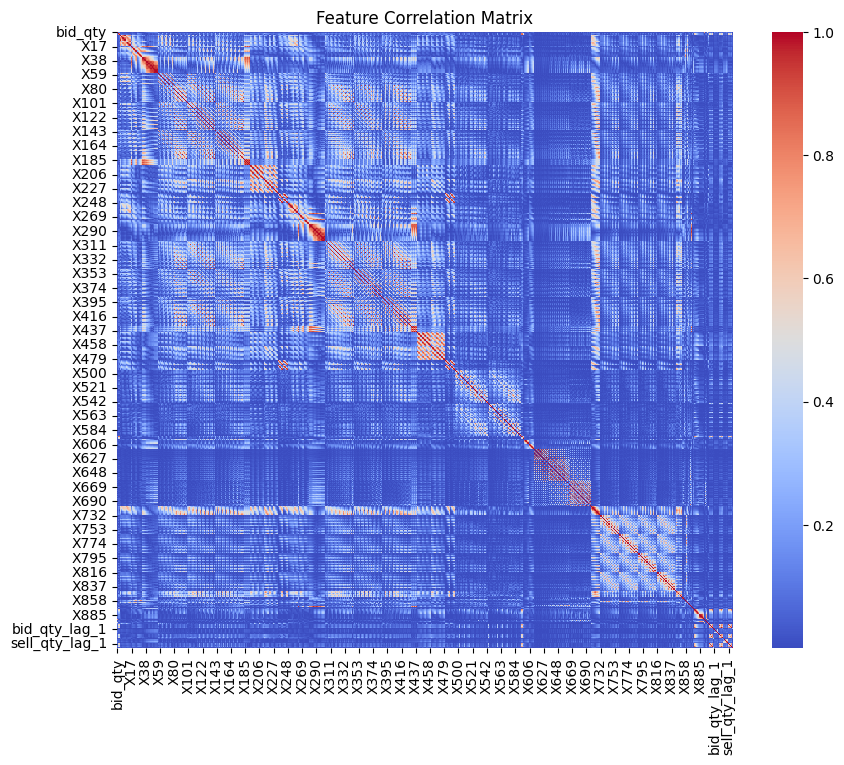

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap='coolwarm', square=True)
plt.title('Feature Correlation Matrix')
plt.show()

In [81]:
X_uncorrelated = X.drop(columns=to_drop)

# Step 5: Reattach the label
df_uncorrelated = X_uncorrelated.copy()
df_uncorrelated['label'] = y.loc[df_uncorrelated.index]  # Ensure index alignmen

In [72]:
# Set a threshold (e.g., 0.9 or 0.95 for high correlation)
threshold = 0.95

# Find index pairs where correlation > threshold
high_corr_pairs = [(col, row) for col in upper.columns for row in upper.index if upper.loc[row, col] > threshold]

# Display those pairs with correlation values
for col, row in high_corr_pairs:
    print(f"{col} - {row} : correlation = {corr_matrix.loc[row, col]:.2f}")

volume - buy_qty : correlation = 0.95
X4 - X3 : correlation = 0.97
X5 - X4 : correlation = 0.98
X6 - X5 : correlation = 0.96
X7 - X1 : correlation = 0.97
X7 - X6 : correlation = 0.99
X8 - X1 : correlation = 0.98
X8 - X6 : correlation = 0.97
X8 - X7 : correlation = 0.99
X12 - X11 : correlation = 0.96
X13 - X12 : correlation = 0.96
X15 - X14 : correlation = 0.98
X16 - X9 : correlation = 0.96
X16 - X15 : correlation = 0.99
X23 - X22 : correlation = 0.95
X24 - X23 : correlation = 0.96
X31 - X30 : correlation = 0.95
X32 - X31 : correlation = 0.96
X34 - X33 : correlation = 0.97
X35 - X33 : correlation = 0.99
X35 - X34 : correlation = 0.95
X36 - X33 : correlation = 0.95
X36 - X34 : correlation = 0.99
X36 - X35 : correlation = 0.96
X37 - X35 : correlation = 0.97
X38 - X36 : correlation = 0.98
X40 - X39 : correlation = 0.95
X41 - X39 : correlation = 1.00
X42 - X40 : correlation = 1.00
X42 - X41 : correlation = 0.95
X43 - X39 : correlation = 0.97
X43 - X41 : correlation = 0.99
X44 - X40 : correl

In [73]:
# Drop the correlated columns from original DataFrame
df_uncorrelated = corr_matrix.drop(columns=to_drop)

print(f"🗑️ Removed {len(to_drop)} highly correlated features (threshold = {threshold})")
print("Dropped features:")
for col in to_drop:
    print(f" - {col}")

🗑️ Removed 288 highly correlated features (threshold = 0.95)
Dropped features:
 - volume
 - X4
 - X5
 - X6
 - X7
 - X8
 - X12
 - X13
 - X15
 - X16
 - X23
 - X24
 - X31
 - X32
 - X34
 - X35
 - X36
 - X37
 - X38
 - X40
 - X41
 - X42
 - X43
 - X44
 - X45
 - X46
 - X47
 - X48
 - X49
 - X50
 - X51
 - X52
 - X53
 - X54
 - X55
 - X56
 - X69
 - X72
 - X75
 - X78
 - X87
 - X90
 - X93
 - X96
 - X104
 - X110
 - X114
 - X116
 - X120
 - X122
 - X128
 - X132
 - X134
 - X135
 - X138
 - X140
 - X146
 - X152
 - X156
 - X157
 - X158
 - X162
 - X163
 - X164
 - X170
 - X174
 - X176
 - X180
 - X182
 - X187
 - X188
 - X190
 - X191
 - X199
 - X200
 - X201
 - X202
 - X203
 - X204
 - X205
 - X206
 - X207
 - X208
 - X209
 - X210
 - X211
 - X212
 - X241
 - X242
 - X243
 - X244
 - X245
 - X246
 - X247
 - X251
 - X252
 - X254
 - X255
 - X259
 - X260
 - X262
 - X263
 - X270
 - X271
 - X279
 - X281
 - X282
 - X283
 - X284
 - X285
 - X288
 - X289
 - X290
 - X291
 - X292
 - X293
 - X294
 - X295
 - X296
 - X297
 - X298

In [83]:
df_uncorrelated.columns.tolist()

['bid_qty',
 'ask_qty',
 'buy_qty',
 'sell_qty',
 'X1',
 'X2',
 'X3',
 'X9',
 'X10',
 'X11',
 'X14',
 'X17',
 'X18',
 'X19',
 'X20',
 'X21',
 'X22',
 'X25',
 'X26',
 'X27',
 'X28',
 'X29',
 'X30',
 'X33',
 'X39',
 'X57',
 'X58',
 'X59',
 'X60',
 'X61',
 'X62',
 'X63',
 'X64',
 'X65',
 'X66',
 'X67',
 'X68',
 'X70',
 'X71',
 'X73',
 'X74',
 'X76',
 'X77',
 'X79',
 'X80',
 'X81',
 'X82',
 'X83',
 'X84',
 'X85',
 'X86',
 'X88',
 'X89',
 'X91',
 'X92',
 'X94',
 'X95',
 'X97',
 'X98',
 'X99',
 'X100',
 'X101',
 'X102',
 'X103',
 'X105',
 'X106',
 'X107',
 'X108',
 'X109',
 'X111',
 'X112',
 'X113',
 'X115',
 'X117',
 'X118',
 'X119',
 'X121',
 'X123',
 'X124',
 'X125',
 'X126',
 'X127',
 'X129',
 'X130',
 'X131',
 'X133',
 'X136',
 'X137',
 'X139',
 'X141',
 'X142',
 'X143',
 'X144',
 'X145',
 'X147',
 'X148',
 'X149',
 'X150',
 'X151',
 'X153',
 'X154',
 'X155',
 'X159',
 'X160',
 'X161',
 'X165',
 'X166',
 'X167',
 'X168',
 'X169',
 'X171',
 'X172',
 'X173',
 'X175',
 'X177',
 'X178',
 'X

In [85]:
train_dff = df_uncorrelated.copy()

In [86]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression  # for continuous targets

def compute_mi_for_time_series(train_dff, target_col='label'):
    X = train_dff.drop(columns=[target_col])
    y = train_dff[target_col]
    
    mi_scores = mutual_info_regression(X, y, discrete_features=False, random_state=42, n_jobs=-1)
    mi_series = pd.Series(mi_scores, index=X.columns)
    return mi_series.sort_values(ascending=False)

# Example usage:
mi_result = compute_mi_for_time_series(train_df, target_col='label')
print(mi_result)

X854                      0.377411
X853                      0.366710
X98                       0.190442
X140                      0.190442
X182                      0.190442
                            ...   
ask_qty_rolling_skew_5    0.000399
volume_rolling_skew_5     0.000000
X623                      0.000000
ask_qty_lag_2             0.000000
bid_qty                   0.000000
Length: 910, dtype: float64


In [88]:
# Print top features
print("🔍 Top Features by Mutual Information:")
print(mi_result)

# Optional: Only top 10 features
print("\n📌 Top 10 Important Features:")
print(mi_result.head(10))


🔍 Top Features by Mutual Information:
X854                      0.377411
X853                      0.366710
X98                       0.190442
X140                      0.190442
X182                      0.190442
                            ...   
ask_qty_rolling_skew_5    0.000399
volume_rolling_skew_5     0.000000
X623                      0.000000
ask_qty_lag_2             0.000000
bid_qty                   0.000000
Length: 910, dtype: float64

📌 Top 10 Important Features:
X854    0.377411
X853    0.366710
X98     0.190442
X140    0.190442
X182    0.190442
X694    0.181576
X387    0.181519
X429    0.181519
X345    0.181519
X426    0.179674
dtype: float64


In [89]:
# Print all columns with their MI scores
print("📋 All Columns with Mutual Information Scores:\n")
for feature, score in mi_result.items():
    print(f"{feature:<30}: {score:.6f}")

📋 All Columns with Mutual Information Scores:

X854                          : 0.377411
X853                          : 0.366710
X98                           : 0.190442
X140                          : 0.190442
X182                          : 0.190442
X694                          : 0.181576
X387                          : 0.181519
X429                          : 0.181519
X345                          : 0.181519
X426                          : 0.179674
X384                          : 0.177978
X95                           : 0.177125
X862                          : 0.176874
X137                          : 0.176331
X688                          : 0.175943
X179                          : 0.174060
X342                          : 0.172556
X691                          : 0.168006
X883                          : 0.168004
X181                          : 0.167009
X685                          : 0.165908
X882                          : 0.164868
X427                          : 0.164608
X180      

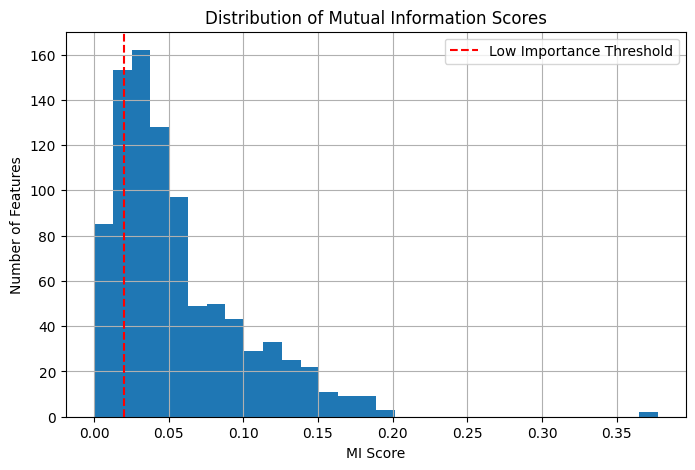

In [90]:
import matplotlib.pyplot as plt

# Histogram of MI scores
mi_result.hist(bins=30, figsize=(8,5))
plt.axvline(x=0.02, color='red', linestyle='--', label='Low Importance Threshold')
plt.title("Distribution of Mutual Information Scores")
plt.xlabel("MI Score")
plt.ylabel("Number of Features")
plt.legend()
plt.show()

In [91]:
threshold = 0.02  # choose based on above distribution
important_features = mi_result[mi_result >= threshold].index.tolist()

# Filter dataset
df_filtered = train_df[important_features + ['label']]  # Include target column

print(f"✅ Retained {len(important_features)} informative features.")
print(f"🗑️ Removed {train_df.shape[1] - 1 - len(important_features)} weak features.")

removed_features = mi_result[mi_result < threshold].index.tolist()
print("Removed low-MI features:")
for col in removed_features:
    print(f" - {col} ({mi_result[col]:.6f})")

✅ Retained 723 informative features.
🗑️ Removed 187 weak features.
Removed low-MI features:
 - X517 (0.019932)
 - X521 (0.019928)
 - X566 (0.019896)
 - X394 (0.019890)
 - X395 (0.019781)
 - X202 (0.019752)
 - X570 (0.019691)
 - X104 (0.019517)
 - X358 (0.019432)
 - X642 (0.019390)
 - X146 (0.019355)
 - X468 (0.019348)
 - X62 (0.019339)
 - X743 (0.019089)
 - X105 (0.019058)
 - X440 (0.019036)
 - X823 (0.018806)
 - X497 (0.018785)
 - X26 (0.018738)
 - X775 (0.018680)
 - X312 (0.018541)
 - X65 (0.018517)
 - X544 (0.018477)
 - X644 (0.018404)
 - X803 (0.018211)
 - X447 (0.018099)
 - X265 (0.018020)
 - X515 (0.017987)
 - X351 (0.017985)
 - X393 (0.017938)
 - ask_qty_rolling_std_5 (0.017936)
 - X309 (0.017907)
 - X18 (0.017857)
 - X106 (0.017749)
 - X1 (0.017695)
 - X193 (0.017655)
 - X609 (0.017608)
 - X64 (0.017596)
 - X353 (0.017583)
 - X739 (0.017565)
 - X221 (0.017377)
 - X316 (0.017372)
 - X63 (0.017350)
 - X102 (0.017291)
 - X194 (0.017261)
 - X201 (0.017261)
 - X771 (0.017132)
 - X54

In [92]:
required_cols = {"X863", "X856", "X598", "X862", "X385", "X852", "X603", "X860", "X674",
        "X415", "X345", "X855", "X174", "X302", "X178", "X168", "X612",
        "buy_qty", "sell_qty", "volume", "X888", "X421", "X333"}
available_cols = set(train_dff.columns)

if required_cols.issubset(available_cols):
    print("all required col are present")
else:
    print("missing:",required_cols-available_cols)

missing: {'X612', 'X385', 'X421', 'X888', 'volume', 'X333', 'X174', 'X302'}


In [107]:
from sklearn.model_selection import train_test_split

x = df_filtered.drop(columns=["label"])
y = df_filtered["label"]

x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=0.2, random_state=42,)

In [111]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import numpy as np
from lightgbm.callback import early_stopping, log_evaluation

# Advanced LGBM configuration
model = LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    metric='rmse',
    n_estimators=10000,               # Large number with early stopping
    learning_rate=0.01,               # Smaller for smoother convergence
    num_leaves=64,                    # Controls model complexity
    max_depth=-1,                     # No depth limit (can be tuned)
    subsample=0.8,                    # Row sampling
    colsample_bytree=0.8,             # Feature sampling
    reg_alpha=1.0,                    # L1 regularization
    reg_lambda=1.0,                   # L2 regularization
    random_state=42,
    n_jobs=-1                         # Use all CPU cores
)

model.fit(
    x_train, y_train,
    eval_set=[(x_val, y_val)],
    eval_metric='rmse',
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(period=100)
    ]
)

# Predict on validation set
y_pred = model.predict(x_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'✅ Validation RMSE: {rmse:.4f}')
print("🔍 Evaluation on Selected Features:")
print("MSE:", mean_squared_error(y_val, y_pred))
print("MAE:", mean_absolute_error(y_val, y_pred))
print("R² Score:", r2_score(y_val, y_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.294575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 183397
[LightGBM] [Info] Number of data points in the train set: 105884, number of used features: 723
[LightGBM] [Info] Start training from score 0.077416
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.758299
[200]	valid_0's rmse: 0.621656
[300]	valid_0's rmse: 0.540641
[400]	valid_0's rmse: 0.480892
[500]	valid_0's rmse: 0.434244
[600]	valid_0's rmse: 0.397152
[700]	valid_0's rmse: 0.366794
[800]	valid_0's rmse: 0.341704
[900]	valid_0's rmse: 0.320743
[1000]	valid_0's rmse: 0.302658
[1100]	valid_0's rmse: 0.287096
[1200]	valid_0's rmse: 0.273382
[1300]	valid_0's rmse: 0.261374
[1400]	valid_0's rmse: 0.250364
[1500]	valid_0's rmse: 0.240537
[1600]	valid_0's rmse: 0.231624
[1700]	valid_0's rmse: 0.223897
[1800]	valid_0's rmse: 0.216682
[1900]	valid_0's rmse: 0.

In [113]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_pred = model.predict(x_val)

print("🔍 Evaluation on Selected Features:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

🔍 Evaluation on Selected Features:
MSE: 0.012314932568194605
MAE: 0.06603430759676289
R² Score: 0.9882017749627073


In [115]:
# Compute Pearson correlation coefficient
from scipy.stats import pearsonr
corr_coef, p_value = pearsonr(y_val, y_pred)

print(f"📈 Pearson Correlation Coefficient: {corr_coef:.4f}")
print(f"📉 P-value: {p_value:.4e}")

📈 Pearson Correlation Coefficient: 0.9944
📉 P-value: 0.0000e+00


In [96]:
importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance_Gain': model.booster_.feature_importance(importance_type='gain'),
    'Importance_Split': model.booster_.feature_importance(importance_type='split'),
})

# Sort by Gain
importance_df = importance_df.sort_values(by='Importance_Gain', ascending=False)
print(importance_df.head(10))

    Feature  Importance_Gain  Importance_Split
174    X272     20507.928574                14
24     X428     12622.381630                23
33     X890     10663.510962                46
23     X180      9576.112238                25
253    X885      6963.254921                14
192    X886      6694.123379                23
35     X344      5859.751335                32
18     X883      5825.227999                27
134    X879      5049.662302                 8
100    X887      4873.926647                24


In [97]:
print(importance_df.head())

    Feature  Importance_Gain  Importance_Split
174    X272     20507.928574                14
24     X428     12622.381630                23
33     X890     10663.510962                46
23     X180      9576.112238                25
253    X885      6963.254921                14


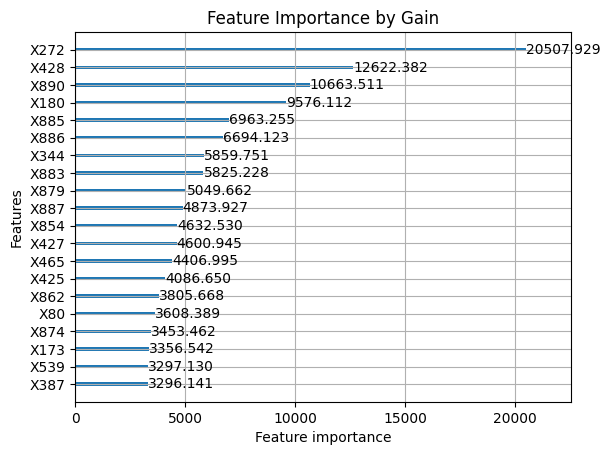

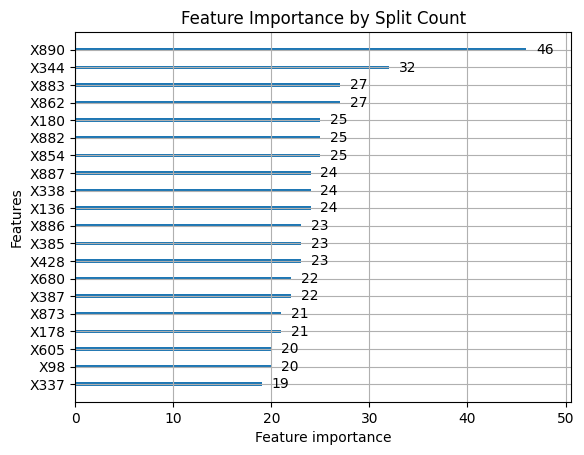

In [98]:
# Gain-based (better for interpretation)
from lightgbm import plot_importance
plot_importance(model, importance_type='gain', max_num_features=20, title='Feature Importance by Gain')
plt.show()

# Split-based (number of times feature was used)
plot_importance(model, importance_type='split', max_num_features=20, title='Feature Importance by Split Count')
plt.show()


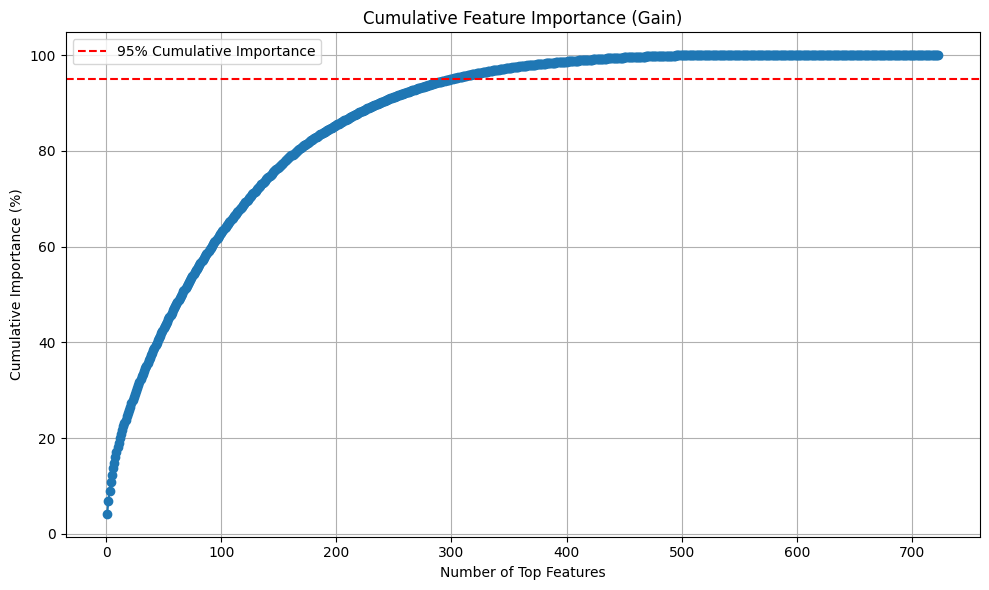

In [99]:
import matplotlib.pyplot as plt

# Normalize and compute cumulative gain
importance_df['Gain (%)'] = 100 * importance_df['Importance_Gain'] / importance_df['Importance_Gain'].sum()
importance_df['Split (%)'] = 100 * importance_df['Importance_Split'] / importance_df['Importance_Split'].sum()
importance_df['Cumulative_Gain (%)'] = importance_df['Gain (%)'].cumsum()

# Plot cumulative gain importance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(importance_df)+1), importance_df['Cumulative_Gain (%)'], marker='o')
plt.axhline(y=95, color='r', linestyle='--', label='95% Cumulative Importance')
plt.title("Cumulative Feature Importance (Gain)")
plt.xlabel("Number of Top Features")
plt.ylabel("Cumulative Importance (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [100]:
# Step 1: Sort features by gain
importance_df = importance_df.sort_values(by='Importance_Gain', ascending=False)

# Step 2: Compute cumulative gain
importance_df['Cumulative_Gain'] = importance_df['Importance_Gain'].cumsum()
importance_df['Cumulative_Gain'] /= importance_df['Importance_Gain'].sum()

# Step 3: Select top 95% gain features
top_95_features = importance_df[importance_df['Cumulative_Gain'] <= 0.95]['Feature'].tolist()

# Step 4: Subset the original training data (not the importance_df)
X_selected = x_train[top_95_features]

In [101]:
# Step 1: Keep only top features + label
selected_features = top_95_features  # from your feature importance step
df_selected = df_filtered[selected_features + ['label']]  # ensure label is added back

In [102]:
print(df_selected)

                         X272      X428      X890      X180      X885  \
timestamp                                                               
2023-10-01 00:00:00  0.426640  0.171591  2.170357  0.086692  1.583839   
2023-10-01 00:01:00  0.436555  0.171077  2.171050  0.086571  1.583839   
2023-10-01 00:02:00  0.435884  0.170384  2.171741  0.086451  1.583839   
2023-10-01 00:03:00  0.440367  0.169529  2.172432  0.086331  1.583839   
2023-10-01 00:04:00  0.456264  0.169040  2.173123  0.086211  1.583839   
...                       ...       ...       ...       ...       ...   
2023-12-31 23:55:00 -0.890262  0.289570  1.944820  0.390876  1.104734   
2023-12-31 23:56:00 -0.884752  0.288187  1.945004  0.390334  1.104734   
2023-12-31 23:57:00 -0.864537  0.287540  1.945187  0.389792  1.104734   
2023-12-31 23:58:00 -0.880366  0.286970  1.945371  0.389251  1.104734   
2023-12-31 23:59:00 -0.892217  0.285986  1.945554  0.388711  1.104734   

                         X886      X344      X883 

In [103]:
# Step 2: Split into features (X) and target (y)
X = df_selected.drop(columns=['label'])
y = df_selected['label']

# Step 3: Split into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
from lightgbm import LGBMRegressor

model=LGBMRegressor(n_estimators=100, learning_rate=0.1,random_state=42)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75277
[LightGBM] [Info] Number of data points in the train set: 105884, number of used features: 299
[LightGBM] [Info] Start training from score 0.077416


LGBMRegressor(random_state=42)

In [105]:
y_preds = model.predict(X_test)

print("🔍 Evaluation on Selected Features:")
print("MSE:", mean_squared_error(y_test, y_preds))
print("MAE:", mean_absolute_error(y_test, y_preds))
print("R² Score:", r2_score(y_test, y_preds))

🔍 Evaluation on Selected Features:
MSE: 0.19051244235428555
MAE: 0.32570278958476206
R² Score: 0.8174810414224121


In [ ]:
X_sample = df_filtered.sample(n=5000, random_state=42)

In [ ]:
# Drop the target column for correlation analysis
X = X_sample.drop(columns=['label'])

# Compute Pearson correlation matrix
corr_matrix = X.corr().abs()

In [ ]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than threshold
threshold = 0.9
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]


In [ ]:
# Drop the correlated columns from original DataFrame
df_uncorrelated = corr_matrix.drop(columns=to_drop)

print(f"🗑️ Removed {len(to_drop)} highly correlated features (threshold = {threshold})")
print("Dropped features:")
for col in to_drop:
    print(f" - {col}")


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap='coolwarm', square=True)
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
print(train_df.index)

In [ ]:
train_df.isnull().values.any()
train_df.isnull().sum()
total_missing = train_df.isnull().sum().sum()
if total_missing == 0:
    print("✅ No missing values found in the dataset.")
else:
    print(f"⚠️ Total missing value")

In [ ]:
train_df.index = pd.to_datetime(train_df.index)
frequency = train_df.index.to_series().diff().mode([0])
print(f"{frequency}")

In [ ]:
## Ensure timestamp is the index and in datetime format
train_df.index = pd.to_datetime(train_df.index, errors='coerce')

# If timestamp is already the index, just sort by index:
train_df.sort_index(inplace=True)


# Extract extended time-based features from index
time_features = pd.DataFrame({
    'hour': train_df.index.hour,
    'minute': train_df.index.minute,
    'day': train_df.index.day,
    'dayofweek': train_df.index.dayofweek,
    'month': train_df.index.month,
    'is_weekend': train_df.index.dayofweek.isin([5, 6]).astype(int),
    'is_month_start': train_df.index.is_month_start.astype(int),
    'is_month_end': train_df.index.is_month_end.astype(int),
    
     #Optional: Sine/cosine encodings for cyclical time variables
    'hour_sin': np.sin(2 * np.pi * train_df.index.hour / 24),
    'hour_cos': np.cos(2 * np.pi * train_df.index.hour / 24),
    'dayofweek_sin': np.sin(2 * np.pi * train_df.index.dayofweek / 7),
    'dayofweek_cos': np.cos(2 * np.pi * train_df.index.dayofweek / 7),
    'month_sin': np.sin(2 * np.pi * train_df.index.month / 12),
    'month_cos': np.cos(2 * np.pi * train_df.index.month / 12),
}, index=train_df.index)

# Add all time features to the original DataFrame
train_df = pd.concat([train_df, time_features], axis=1)


In [ ]:
train_df.head()

In [ ]:
train_df = train_df.asfreq('1min')

# Step 3: Select numeric features (anonymized + quantity)
feature_cols = [col for col in train_df.columns if train_df[col].dtype in ['float32', 'float64']]

# Step 4: Apply rolling with min_periods=1 (so early rows stay)
rolling_window = 5  # minutes
rolling_mean = train_df[feature_cols].rolling(window=rolling_window, min_periods=1).mean().add_suffix(f'_mean_{rolling_window}min')
rolling_std = train_df[feature_cols].rolling(window=rolling_window, min_periods=1).std().add_suffix(f'_std_{rolling_window}min')

# Optional: fill NaNs forward to preserve rows
rolling_mean = rolling_mean.ffill()
rolling_std = rolling_std.ffill()

# Step 5: Concatenate original + rolling features
train_df_rolled = pd.concat([train_df, rolling_mean, rolling_std], axis=1)

# Step 6: Drop any remaining rows with NaNs in important columns (e.g., label)
train_df_rolled = train_df_rolled.dropna(subset=['label'])

print(f"✅ Rolling features added. Final shape: {train_df_rolled.shape}")

In [ ]:
train_df_rolled = train_df.copy()

In [ ]:
train_df_rolled.isna().sum().sum()

In [ ]:
train_df_rolled = train_df_rolled.ffill().bfill()


In [ ]:
from sklearn.feature_selection import VarianceThreshold


n_before = train_df_rolled.shape[0]
train_df_cleaned = train_df_rolled.dropna()
n_after = train_df_cleaned.shape[0]
print(f"🧹 Removed {n_before - n_after} rows with NaNs")# 1. Drop rows with NaNs in label (after rolling)

# 2. Split label and features
X = train_df_cleaned.drop(columns=['label'])
y = train_df_cleaned['label']

# 3. Time-aware train-validation split (last 20% for validation)
split_index = int(len(X) * 0.8)
X_train, X_val = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_val = y.iloc[:split_index], y.iloc[split_index:]

In [ ]:
train_df_cleaned.shape

In [ ]:
import gc
gc.collect()

In [ ]:
from sklearn.feature_selection import VarianceThreshold

# 2. Remove constant features (zero variance) from training set only
n_before_const = X_train.shape[1]
X_train = X_train.loc[:, X_train.nunique() > 1]
n_after_const = X_train.shape[1]
n_const_removed = n_before_const - n_after_const
print(f"🗑️ Removed {n_const_removed} constant (zero variance) columns")

# Apply the same columns filtering to validation set
X_val = X_val[X_train.columns]

# 3. Apply low variance filter (VarianceThreshold) on training set only
selector = VarianceThreshold(1e-5)
X_train_selected = selector.fit_transform(X_train)
selected_columns = X_train.columns[selector.get_support()]

n_after_var = len(selected_columns)
n_var_removed = X_train.shape[1] - n_after_var
print(f"⚠️ Removed {n_var_removed} low-variance columns (threshold < 1e-5)")
print(f"✅ {n_after_var} columns retained")

# 4. Apply same selection to validation set
X_train = pd.DataFrame(X_train_selected, columns=selected_columns, index=X_train.index)
X_val = pd.DataFrame(selector.transform(X_val), columns=selected_columns, index=X_val.index)

# Now X_train, X_val are ready for modeling


In [ ]:
# ---- Step 4: Scaling ----
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ---- Step 5: PCA ----
#pca = PCA(n_components=0.95, random_state=42)
#X_train_pca = pca.fit_transform(X_train_scaled)
#X_val_pca = pca.transform(X_val_scaled)

#print(f"✅ PCA complete. Components retained: {pca.n_components_}")
#print(f"PCA Train shape: {X_train_pca.shape}, PCA Validation shape: {X_val_pca.shape}")

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Advanced XGBRegressor with tuned hyperparameters
model = XGBRegressor(
    n_estimators=1500,              # more trees for better performance
    max_depth=8,                    # deeper trees
    learning_rate=0.03,             # slower learning for better convergence
    subsample=0.9,                  # more robust bagging
    colsample_bytree=0.7,
    min_child_weight=3,            # to avoid overfitting small leaves
    gamma=0.1,                     # minimum loss reduction
    reg_alpha=1.0,                 # L1 regularization
    reg_lambda=1.0,                # L2 regularizat
    random_state=42,
    tree_method="hist",           # faster tree construction, use "gpu_hist" if on GPU
    n_jobs=-1
)

# Fit the model with validation set for early stopping
model.fit(
    X_train_scaled, y_train,
)

# Predictions
y_pred = model.predict(X_val_scaled)


mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"📉 MAE: {mae:.4f}")
print(f"📈 R² Score: {r2:.4f}")

In [ ]:
from scipy.stats import pearsonr

corr, p_val = pearsonr(y_val, y_pred)
print(f"📊 Pearson correlation coefficient: {corr:.4f} (p-value: {p_val:.4e})")


In [ ]:
import joblib

joblib.dump(selector, 'selector.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selected_columns.tolist(), 'selected_features.pkl')
joblib.dump(model, 'model.pkl')  # whatever model you're using
joblib.dump(pca, "pca.pkl")
feature_means = X_train.mean()
joblib.dump(feature_means, 'feature_means.pkl')

In [ ]:
test_df = pd.read_parquet("/kaggle/input/train-test/test.parquet")

In [ ]:
test_df = test_df.drop(columns = ['label'])

In [ ]:
import gc
gc.collect()

In [ ]:
# Get the last timestamp from training data
last_train_time = train_df.index[-1]  # training index is already datetime

# Start test from next minute
start_time = last_train_time + pd.Timedelta(minutes=1)

# Create index for test set
test_df.index = pd.date_range(start=start_time, periods=len(test_df), freq="1min")


In [ ]:
print("Training index dtype:", train_df.index.dtype)
print("First timestamp:", train_df.index[0])
print("Last timestamp:", train_df.index[-1])

In [ ]:
test_df.index.name = "timestamp"


In [ ]:
print(test_df.index)          # Show all timestamps
print(test_df.index[0])       # First timestamp
print(test_df.index[-1])      # Last timestamp
test_df.head()                # Also shows index in table


In [ ]:
constant_cols1 = [col for col in test_df.columns if test_df[col].nunique(dropna=True) == 1]
print("Columns with all unique values:")
print(constant_cols1)

In [ ]:
test_df = test_df.drop(columns = constant_cols1)
print(f"✅ Removed {len(constant_cols1)} constant columns")
print(f"📊 New shape: {train_df.shape}")

In [ ]:
## Ensure timestamp is the index and in datetime format
train_df.index = pd.to_datetime(train_df.index, errors='coerce')

In [ ]:

## Ensure timestamp is the index and in datetime format
train_df.index = pd.to_datetime(train_df.index, errors='coerce')

# Ensure timestamp is the index and sorted
test_df.sort_index(inplace=True)

# Generate time features using test_df's index
test_time_features = pd.DataFrame({
    'hour': test_df.index.hour,
    'minute': test_df.index.minute,
    'day': test_df.index.day,
    'dayofweek': test_df.index.dayofweek,
    'month': test_df.index.month,
    'is_weekend': test_df.index.dayofweek.isin([5, 6]).astype(int),
    'is_month_start': test_df.index.is_month_start.astype(int),
    'is_month_end': test_df.index.is_month_end.astype(int),
    
    # Sine/cosine encodings
    'hour_sin': np.sin(2 * np.pi * test_df.index.hour / 24),
    'hour_cos': np.cos(2 * np.pi * test_df.index.hour / 24),
    'dayofweek_sin': np.sin(2 * np.pi * test_df.index.dayofweek / 7),
    'dayofweek_cos': np.cos(2 * np.pi * test_df.index.dayofweek / 7),
    'month_sin': np.sin(2 * np.pi * test_df.index.month / 12),
    'month_cos': np.cos(2 * np.pi * test_df.index.month / 12),
}, index=test_df.index)

# Concatenate with original test data
test_df = pd.concat([test_df, test_time_features], axis=1)


In [ ]:
# Ensure uniform frequency (1-minute intervals)
test_df = test_df.asfreq('1min')  # assumes timestamp is index and sorted

# Step 1: Select numeric features like in training
feature_cols = [col for col in test_df.columns if test_df[col].dtype in ['float32', 'float64', 'int64']]

# Step 2: Compute rolling mean and std
rolling_window = 5
rolling_mean = test_df[feature_cols].rolling(window=rolling_window, min_periods=1).mean().add_suffix(f'_mean_{rolling_window}min')
rolling_std = test_df[feature_cols].rolling(window=rolling_window, min_periods=1).std().add_suffix(f'_std_{rolling_window}min')

# Step 3: Forward-fill to remove NaNs (especially at the beginning)
rolling_mean = rolling_mean.ffill()
rolling_std = rolling_std.ffill()

# Step 4: Concatenate original and rolling features
test_df_rolled = pd.concat([test_df, rolling_mean, rolling_std], axis=1)

print(f"✅ Rolling features added to test. Final shape: {test_df_rolled.shape}")


In [ ]:
test_df_rolled.isna().sum().sum()

In [ ]:
test_df_rolled = test_df_rolled.ffill().bfill()


In [ ]:
scaler = joblib.load('scaler.pkl')
pca = joblib.load('pca.pkl')
selector = joblib.load('selector.pkl')
selected_features = joblib.load('selected_features.pkl')
feature_means = joblib.load('feature_means.pkl')
model = joblib.load('model.pkl')

In [ ]:
#  Ensure all selected features exist in test_df_rolled
for feat in selected_features:
    if feat not in test_df_rolled.columns:
        test_df_rolled[feat] = feature_means.get(feat, 0)  # fill with training mean if missing
    else:
        test_df_rolled[feat] = test_df_rolled[feat].fillna(feature_means.get(feat, 0))

# Select only required features in the correct order
X_test = test_df_rolled[selected_features]

In [ ]:
# efficient code
#import pandas as pd

# Prepare a dict for new columns (those missing in test_df_rolled)
#new_cols = {}

for feat in selected_features:
    if feat not in test_df_rolled.columns:
        new_cols[feat] = feature_means.get(feat, 0)  # constant series value for the missing feature

# Create a DataFrame of missing features with same index as test_df_rolled
if new_cols:
    new_cols_df = pd.DataFrame(new_cols, index=test_df_rolled.index)
    # Concatenate once with the original DataFrame
    test_df_rolled = pd.concat([test_df_rolled, new_cols_df], axis=1)

# Now fill NaNs for existing columns in selected_features
for feat in selected_features:
    if feat in test_df_rolled.columns:
        test_df_rolled[feat].fillna(feature_means.get(feat, 0), inplace=True)

# Finally select only the features you want
X_test = test_df_rolled[selected_features]


In [ ]:
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
test_preds= model.predict(X_test_pca)

In [ ]:
sample_submission = pd.read_csv('/kaggle/input/train-test/sample_submission.csv')
sample_submission['prediction'] = test_preds
sample_submission.to_csv('sample5_submission.csv',index = False )

In [ ]:
print(test_df.index)

In [ ]:
test_df.head()